# Решение с помощью случайного леса (RandomForest)
Воспользуемся одним из типовых методов решения задач с помощью машинного обучения - [деревья решений](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) и [случайный лес](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

## Предобработаем наши данные

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(0)

titanic_df = pd.read_csv("../titanic.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Сформируем входные и выходные данные.

In [178]:
# C выходным вектором все просто - достаем переменную, которую хотим предсказать
y = titanic_df.Survived

# А вот с входным вектором нужно будет поработать
# Удалим все переменные, которые очень врядли помогут нам в решении нашей задачи
X = titanic_df.drop(["PassengerId", "Name", "Ticket", "Cabin", "Survived"], axis=1) 

# Также взглянем на количество пустых значений
print(f"Количество пустых значений: \n{X.isnull().sum()}")

Количество пустых значений: 
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


Заполним нулевые значения.

In [179]:
# Переменную Embarked заполним тем значением, которое встречается чаще всего.
X.Embarked = X.Embarked.fillna(X.Embarked.mode()[0])

# Переменную Age заполним по медианному значения возраста 
X.Age = X.Age.fillna(X.Age.median())

X.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Переведем строковые переменные в категориальные.

In [180]:
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Удалим лишние столбцы, сформировнные с помощью метода get_dummies().

In [181]:
X = X.drop(["Sex_female", "Embarked_Q"], axis=1)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,1,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


Сформируем тестовые и тренировочные датасеты.

In [182]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Мы провели предобработку данных. Теперь мы можем с уверенностью начать работать с обучением моделей на этих данных.
## Обучим модель и сделаем предсказание

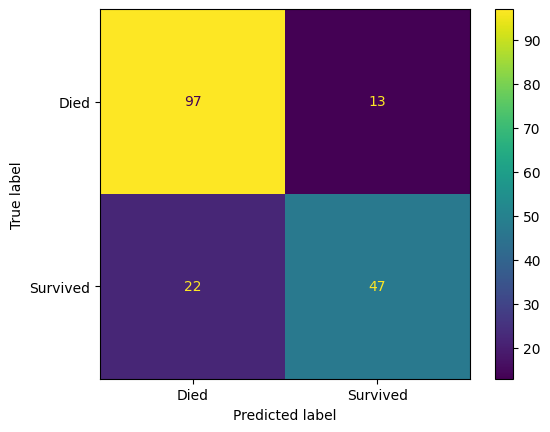

In [183]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Выделим параметры леса для перебора
parameters = {
    "n_estimators": range(5, 51, 5),
    "max_depth": range(1, 20, 2),
    "min_samples_split": range(2, 151, 20),
    "min_samples_leaf": range(1, 50, 5),
    "min_impurity_decrease": [0.001, 0.01, 0.1, 0.2, 0.5]
}

# Создадим классификатор, натренируем его
clf_rf = RandomForestClassifier()
grid_search = RandomizedSearchCV(
    clf_rf, 
    parameters, 
    cv=5, 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Возьмем лучший найденный классификатор и сделаем предсказание
best_clf_rf = grid_search.best_estimator_
y_pred = best_clf_rf.predict(X_test)

# Изобразим матрицу ошибок
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred), 
    display_labels=["Died", "Survived"]
)

cmd.plot()
plt.show()

Взглянем на полученные метрики.

In [184]:
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score
)

scores = pd.DataFrame({
    "Accuracy": [accuracy_score(y_test, y_pred)],
    "Precision": [precision_score(y_test, y_pred)],
    "Recall": [recall_score(y_test, y_pred)],
    "F1-score": [f1_score(y_test, y_pred)],
    "ROC AUC score": [roc_auc_score(y_test, y_pred)]
})

scores.index = ["Score"]
scores

,Accuracy,Precision,Recall,F1-score,ROC AUC score
Score,0.804469,0.783333,0.681159,0.728682,0.781489


Достанем лучшие найденные параметры для случайного леса.

In [185]:
best_params = grid_search.best_params_
for key, value in best_params.items():
    best_params[key] = [value]

best_params = pd.DataFrame(best_params)
best_params.index = ["Value"]
best_params

,n_estimators,min_samples_split,min_samples_leaf,min_impurity_decrease,max_depth
Value,15,102,6,0.001,11


## Результат на Kaggle
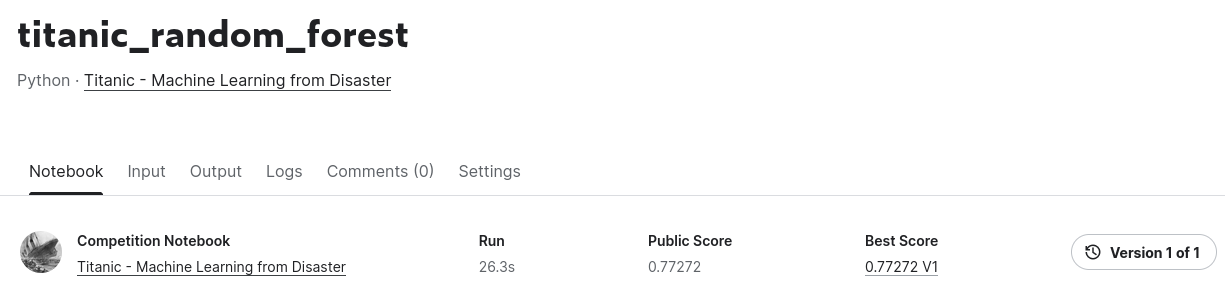
<br><br>*Примерно тот же результат и получился